In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

import os
import pickle

In [2]:
DATA_URL = "https://mikes-junk-drawer.s3.us-east-2.amazonaws.com/pl_xsell.csv"
df = pd.read_csv(DATA_URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CUST_ID                   20000 non-null  object 
 1   TARGET                    20000 non-null  int64  
 2   AGE                       20000 non-null  int64  
 3   GENDER                    20000 non-null  object 
 4   BALANCE                   20000 non-null  float64
 5   OCCUPATION                20000 non-null  object 
 6   AGE_BKT                   20000 non-null  object 
 7   SCR                       20000 non-null  int64  
 8   HOLDING_PERIOD            20000 non-null  int64  
 9   ACC_TYPE                  20000 non-null  object 
 10  ACC_OP_DATE               20000 non-null  object 
 11  LEN_OF_RLTN_IN_MNTH       20000 non-null  int64  
 12  NO_OF_L_CR_TXNS           20000 non-null  int64  
 13  NO_OF_L_DR_TXNS           20000 non-null  int64  
 14  TOT_NO

# Goal

The goal is to create a model that returns the probability that an individual will respond to the direct mail campaign.

In future iterations, we would also aspire to add an estimated look-to-book ratio (i.e. Pr[fund | apply]).

This model will be deployed in an API. We assume that all fields in this data set would be known and supplied when the API is called.

# EDA

In [3]:
obs = df.shape[0]
num_responses = df.TARGET.sum()
response_rate = num_responses/obs

print(f"""
    Obs: {obs}
    Responses: {num_responses}
    Response rate: {response_rate}
      """
      )


    Obs: 20000
    Responses: 2512
    Response rate: 0.1256
      


12.6% is fairly unbalanced but not terrible. It may be worth stratified sampling in the future, but we'll start with a simple 80-20 train-test split.

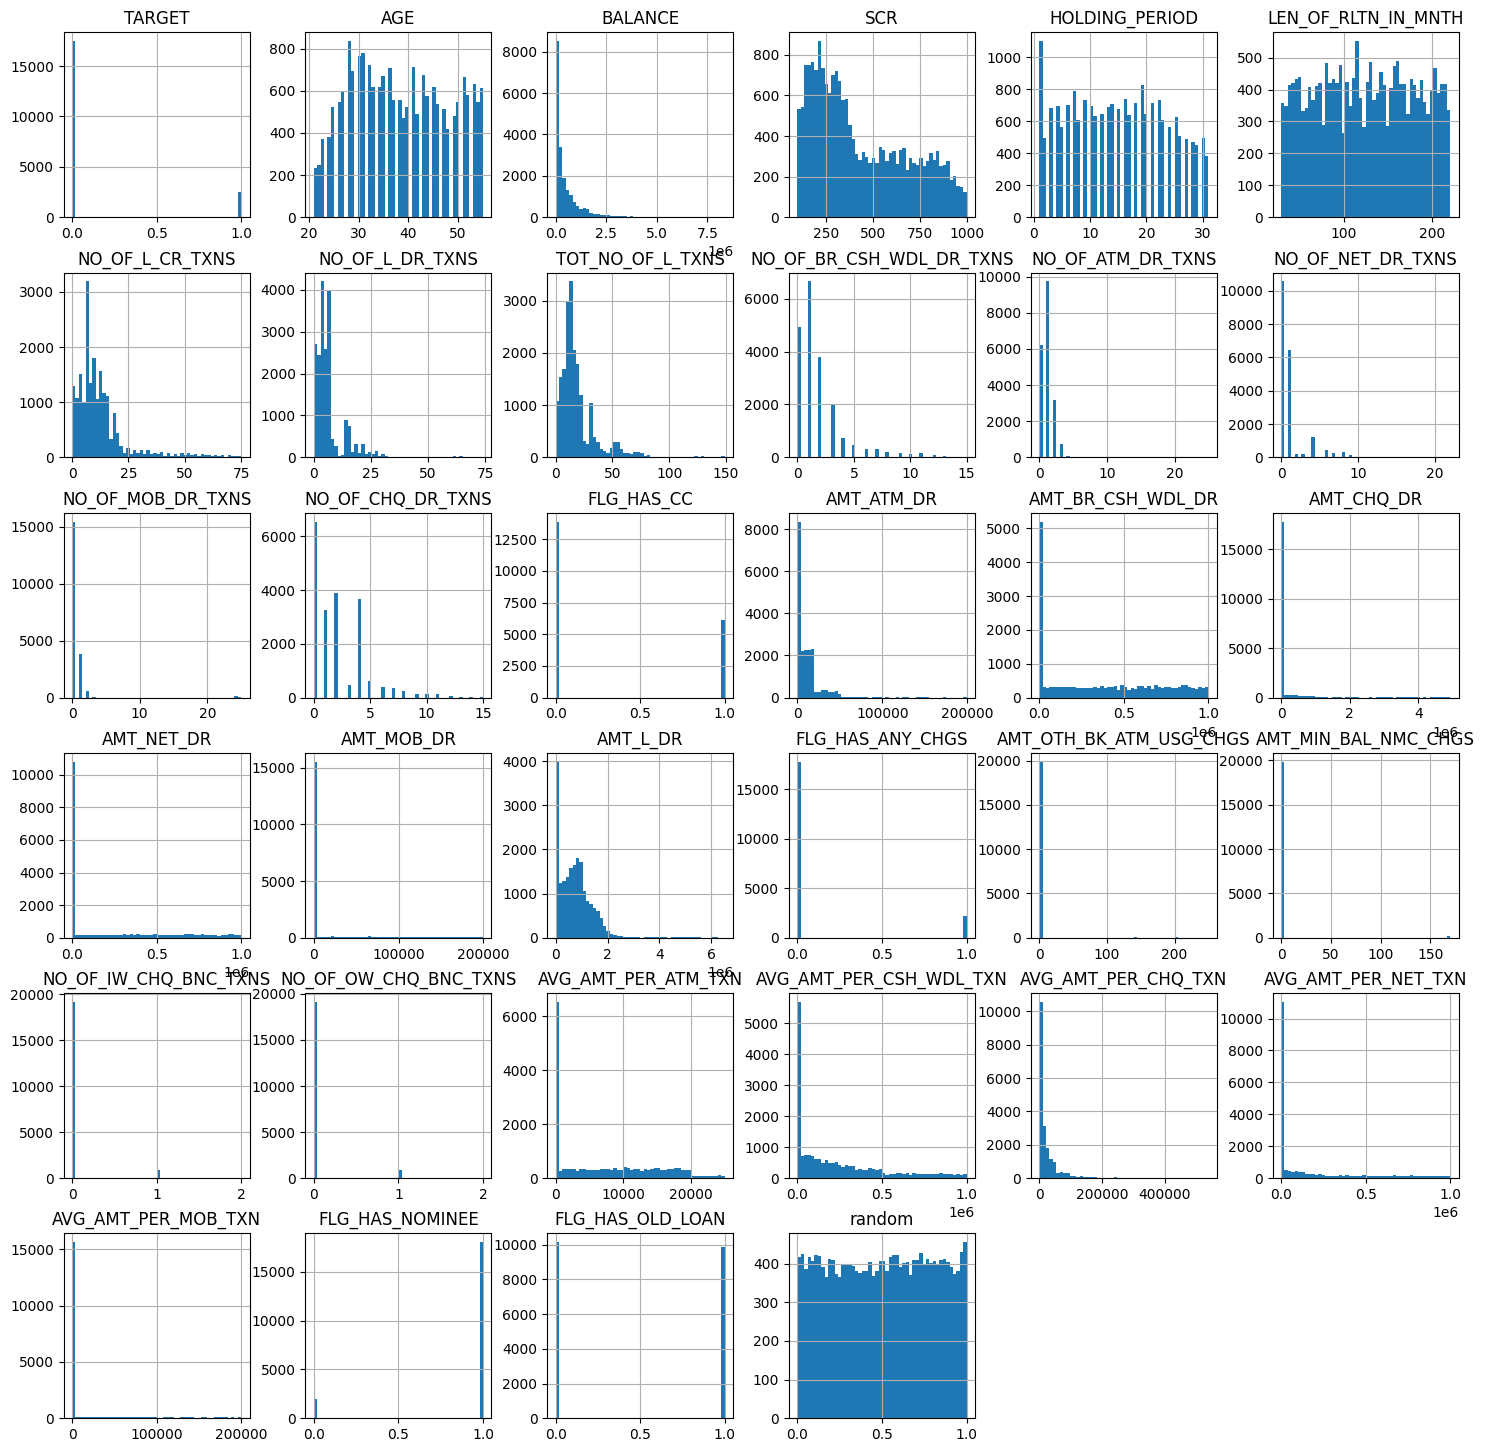

In [4]:
df.select_dtypes(include=['float64','int64']).hist(bins=50,figsize=(18,18))
plt.show()

- There are some flag columns in here. We should take care not to normalize those in transformations.
- There are a _lot_ of zero-inflated variables here. Like `AVG_AMT_PER_NET_TXN`, which is mostly zero but has a long tail rightward. Or `AMT_L_DR`, which is zero inflated but otherwise hase a lognormal-looking distribution.
  - These are good candidates for feature engineering.
- The `random` field should probably be dropped.

We should _not_ transform any of the `FLG_*` fields, but anything else can be standardized.
 

In [6]:
df.select_dtypes(include=['float64','int64']).corr().style.background_gradient(cmap="coolwarm")

,TARGET,AGE,BALANCE,SCR,HOLDING_PERIOD,LEN_OF_RLTN_IN_MNTH,NO_OF_L_CR_TXNS,NO_OF_L_DR_TXNS,TOT_NO_OF_L_TXNS,NO_OF_BR_CSH_WDL_DR_TXNS,NO_OF_ATM_DR_TXNS,NO_OF_NET_DR_TXNS,NO_OF_MOB_DR_TXNS,NO_OF_CHQ_DR_TXNS,FLG_HAS_CC,AMT_ATM_DR,AMT_BR_CSH_WDL_DR,AMT_CHQ_DR,AMT_NET_DR,AMT_MOB_DR,AMT_L_DR,FLG_HAS_ANY_CHGS,AMT_OTH_BK_ATM_USG_CHGS,AMT_MIN_BAL_NMC_CHGS,NO_OF_IW_CHQ_BNC_TXNS,NO_OF_OW_CHQ_BNC_TXNS,AVG_AMT_PER_ATM_TXN,AVG_AMT_PER_CSH_WDL_TXN,AVG_AMT_PER_CHQ_TXN,AVG_AMT_PER_NET_TXN,AVG_AMT_PER_MOB_TXN,FLG_HAS_NOMINEE,FLG_HAS_OLD_LOAN,random
TARGET,1.000000,0.022977,-0.067062,0.078909,-0.135447,-0.023618,0.120284,0.122954,0.134504,0.101909,0.082359,0.097071,0.054477,0.103531,0.100513,0.083251,0.048360,0.060796,0.062121,0.083215,0.095351,0.045783,0.028417,0.005053,0.011601,0.027411,0.074995,-0.002157,0.065239,0.025707,0.076258,0.011784,-0.011555,-0.001504
AGE,0.022977,1.000000,-0.122587,-0.005871,-0.012060,-0.008279,0.030170,0.019602,0.028932,0.024266,0.006757,0.012268,0.001957,0.021800,0.014168,0.019702,0.010351,0.012189,0.004390,0.028908,0.016725,-0.008505,-0.007980,0.016437,-0.014412,-0.005830,0.018692,-0.005078,0.014456,0.000079,0.028288,0.016856,0.010269,-0.004517
BALANCE,-0.067062,-0.122587,1.000000,-0.065300,0.039241,-0.000855,-0.047652,-0.043431,-0.051299,-0.034814,-0.030579,-0.037018,-0.021012,-0.032516,-0.019638,-0.035987,-0.020901,-0.012511,-0.029335,-0.026694,-0.033193,-0.006826,-0.010949,-0.061819,-0.009934,-0.014364,-0.035360,0.005807,-0.023732,-0.019149,-0.028727,-0.004205,-0.028707,-0.004026
SCR,0.078909,-0.005871,-0.065300,1.000000,-0.025174,0.009034,-0.013179,0.009389,-0.004952,0.004827,0.014910,0.006476,0.001236,0.008708,0.030116,0.009744,-0.019841,0.004519,0.023654,-0.012588,0.003485,0.014432,0.007902,0.008682,0.000864,0.006541,0.019440,-0.022531,0.008267,0.025731,-0.015246,-0.001952,0.013333,0.008131
HOLDING_PERIOD,-0.135447,-0.012060,0.039241,-0.025174,1.000000,0.011448,-0.008474,-0.347855,-0.156350,-0.196455,-0.181790,-0.250650,-0.109956,-0.473639,0.001694,-0.173627,-0.048038,-0.173118,-0.198319,-0.104097,-0.228821,-0.006915,-0.077078,-0.006945,-0.040950,-0.066337,-0.167648,0.053490,-0.209996,-0.107639,-0.080625,-0.005034,-0.002751,-0.002089
LEN_OF_RLTN_IN_MNTH,-0.023618,-0.008279,-0.000855,0.009034,0.011448,1.000000,0.021719,0.001878,0.015777,-0.003073,-0.000047,0.005921,-0.003159,0.005685,-0.015797,-0.010014,-0.001699,0.013796,0.001536,0.004806,0.008522,0.019448,-0.006432,-0.008239,0.001705,0.001299,-0.018905,0.007646,0.012910,-0.002317,0.000768,0.010750,-0.000576,0.003609
NO_OF_L_CR_TXNS,0.120284,0.030170,-0.047652,-0.013179,-0.008474,0.021719,1.000000,0.582878,0.936226,0.376076,0.478081,0.543464,0.456309,0.286492,-0.016830,0.436094,0.086327,0.288798,0.146708,0.394123,0.320615,0.231216,0.320125,0.026632,0.002825,0.036372,0.196087,-0.072481,0.296119,-0.070980,0.331736,0.003048,-0.001724,-0.006647
NO_OF_L_DR_TXNS,0.122954,0.019602,-0.043431,0.009389,-0.347855,0.001878,0.582878,1.000000,0.831203,0.566711,0.806728,0.915082,0.763748,0.608018,0.003272,0.699707,0.115308,0.466686,0.303860,0.551018,0.530682,0.177025,0.564558,0.009877,0.059746,0.085200,0.320450,-0.138214,0.496141,-0.040287,0.409491,0.000826,-0.003605,-0.005101
TOT_NO_OF_L_TXNS,0.134504,0.028932,-0.051299,-0.004952,-0.156350,0.015777,0.936226,0.831203,1.000000,0.502433,0.675687,0.767502,0.642399,0.459062,-0.010323,0.601078,0.108965,0.399407,0.231835,0.507941,0.448896,0.234706,0.463086,0.022458,0.027804,0.061762,0.273038,-0.109383,0.417131,-0.065890,0.404073,0.002475,-0.002790,-0.006643
NO_OF_BR_CSH_WDL_DR_TXNS,0.101909,0.024266,-0.034814,0.004827,-0.196455,-0.003073,0.376076,0.566711,0.502433,1.000000,0.252816,0.414579,0.168560,0.156117,0.010869,0.344834,0.320713,0.085463,0.173492,0.464861,0.319195,0.035764,-0.014459,0.010882,0.045698,0.049475,0.239661,-0.127145,0.137317,-0.045247,0.432037,0.008636,0.005678,0.001384


- Holding period has some high correlations with transaction counts. The definition of that field is "Ability to hold money in the account (Range 0-31). So it makes sense that if you're transacting more, you're not holding the money.
  - It's not necessarily worth dropping. In fact, people with high transaction volume compared to others _and_ high holding period could be an important combo. It may indicate higher income (maybe less likely to need a loan).
- Total number of transactions is probably unecessary since we have all the subtypes of transactions as well. It may even be a linear combo of the others. Not adding much value.

Probably should drop `TOT_NO_OF_L_TRXNS`. Nothing else jumps out.

In [7]:
df.select_dtypes(include="object").head()

,CUST_ID,GENDER,OCCUPATION,AGE_BKT,ACC_TYPE,ACC_OP_DATE
0,C7927,M,SELF-EMP,26-30,SA,3/23/2005
1,C6877,M,SAL,46-50,SA,10-11-2008
2,C19922,M,SELF-EMP,36-40,SA,4/26/2012
3,C8183,M,SAL,>50,CA,07-04-2008
4,C12123,M,PROF,36-40,SA,12/29/2001


- We don't need `CUST_ID`
- `ACC_OP_DATE` has multiple formats. It is the account open date. But the field `LEN_OF_RLTN_IN_MNTH` also tells us customer tenure. So let's just drop `ACC_OP_DATE`.
- `AGE_BKT` should be dropped (along with `AGE` ). It could be useful. But there may be fair credit regulation issues with targeting age. If it's something we _really_ wanted to include, it would take a conversation with compliance to make sure we do it correctly. For now, it's easier just to drop it.
- `GENDER` should likewise be dropped for compliance reasons.
- The only categorical fields we'll keep are `OCCUPATION` and `ACC_TYPE`.

# Metric choice

We should consider the economics when deciding on an appropriate utility metric for the model. For this we'll make some assumptions.
- Cost per mailer: \$1.00.
- Value of a loan: The average value of a loan can be ballparked using using a discounted cashflow method. Given the average loan amount, rate, term (in months), and the firm's discount rate.
  - \$10,000 amount, 15.00% rate, 66 month (5.5 year) term
  - A firm discount rate of 5.00%
  - Assuming a loan using these parameters, create an amortization table and calculate the present value of the interest payments.
  - This comes out to about \$1,903.45.
  - For simplicity, we'll assume the expected value of a loan is \$1,900.
- Look-to-book ratio is 20%.
- Expected value of a response is 20% * \$1,900 = \$380

With this we can identify the economics of the confusion matrix.
- True Positive: \$380 - \$1.00 = \$379
- False Positive: -\$1.00
- True Negative: \$0.00
- False Negative: -\$0

We can create a custom score from this info.

In [8]:
def direct_mail_score_func(y_true, y_proba):
    """ Expected profit from campaign.

    This uses the probability of response to calculate the mail cost and origination value.
    It return sthe expected profit from the campaign.
    """
    mail_cost = y_proba.sum() * -1
    origination_value = (y_proba * y_true).sum() * 380
    return origination_value - mail_cost

direct_mail_score = make_scorer(direct_mail_score_func,greater_is_better=True,response_method="predict_proba")

This custom metric can be used in the modelling to explicitly maximize the profit of a campaign.

# Modeling

In [9]:
drop_cols = ["CUST_ID","TARGET","random","TOT_NO_OF_L_TXNS","AGE","AGE_BKT","ACC_OP_DATE","GENDER"]
X = df.drop(columns=drop_cols)
y = df["TARGET"]
# Train-test split used for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=71)

In [10]:
flg_cols = ["FLG_HAS_CC", "FLG_HAS_ANY_CHGS", "FLG_HAS_NOMINEE", "FLG_HAS_OLD_LOAN"]
cat_cols = ["ACC_TYPE","OCCUPATION"]
number_cols = [col for col in X.columns.to_list() if (col not in flg_cols) and (col not in cat_cols)]

num_pipeline = Pipeline([
    ("standardize",StandardScaler())
])

cat_pipeline = Pipeline([
    ("one_hot_encoder",OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ("num_transform", num_pipeline, number_cols),
    ("cat_transform", cat_pipeline, cat_cols)
])

xgb_classifier = XGBClassifier(objective="binary:logistic", seed=71)

model_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("xgb_classifier", xgb_classifier)
])

# model = model_pipeline.fit(X_train, y_train)

# xgb_dir_mail_scores = cross_val_score(model_pipeline,X_train,y_train,scoring=direct_mail_score,cv=5)

param_grid = [
    {
        "xgb_classifier__min_child_weight": [1, 5, 10],    # range [0, Inf]
        "xgb_classifier__gamma": [0.5, 1, 1.5, 2, 5],    # range [0, Inf]
        "xgb_classifier__subsample": [0.6, 0.8, 1.0],    # range (0,1]
        "xgb_classifier__colsample_bytree": [3/32, 5/32, 10/32, 20/32],    # range (0,1]; there are 32 columns
        "xgb_classifier__max_depth": [2, 3, 5]    # range [0, Inf]
    }
]

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring=direct_mail_score)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transform',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['BALANCE',
                                                                          'SCR',
                                                                          'HOLDING_PERIOD',
                                                                          'LEN_OF_RLTN_IN_MNTH',
                                                                          'NO_OF_L_CR_TXNS',
                                                                          'NO_OF_L_DR_TXNS',
                                                                          'NO_OF_BR_CSH_WDL_DR_TXNS',
                                                                          'NO_OF_ATM_DR_TXNS',
                                                                          'NO_OF_NET_DR_TXNS',
                                                                          'NO_OF_MOB_DR_TXNS',
                                                                          'NO_OF_CHQ...
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid=[{'xgb_classifier__colsample_bytree': [0.09375, 0.15625,
                                                               0.3125, 0.625],
                          'xgb_classifier__gamma': [0.5, 1, 1.5, 2, 5],
                          'xgb_classifier__max_depth': [2, 3, 5],
                          'xgb_classifier__min_child_weight': [1, 5, 10],
                          'xgb_classifier__subsample': [0.6, 0.8, 1.0]}],
             scoring=make_scorer(direct_mail_score_func, response_method='predict_proba'))

In [11]:
grid_search.best_params_

{'xgb_classifier__colsample_bytree': 0.625,
 'xgb_classifier__gamma': 0.5,
 'xgb_classifier__max_depth': 5,
 'xgb_classifier__min_child_weight': 1,
 'xgb_classifier__subsample': 0.8}

In [12]:
grid_search.best_score_

np.float64(125046.85965735232)

In [13]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['BALANCE', 'SCR',
                                                   'HOLDING_PERIOD',
                                                   'LEN_OF_RLTN_IN_MNTH',
                                                   'NO_OF_L_CR_TXNS',
                                                   'NO_OF_L_DR_TXNS',
                                                   'NO_OF_BR_CSH_WDL_DR_TXNS',
                                                   'NO_OF_ATM_DR_TXNS',
                                                   'NO_OF_NET_DR_TXNS',
                                                   'NO_OF_MOB_DR_TXNS',
                                                   'NO_OF_CHQ_DR_TXNS',
                                                   'AMT_ATM_DR',
                                                   'AMT_...
                               feature_types=None, gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [14]:
direct_mail_score(best_model,X_test,y_test)

np.float64(98727.55054573994)

The estimated profit of the campaign is \$98,727.

In [15]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

np.float64(0.9170585416829271)

We're not using AUC as the primary utility score. But commonly, a model with an AUC score between 90% and 100% is considered to be pretty good. This model has an AUC score of 91.7%.

Again, we're not optimizing for AUC. We're optimizing for profitability. But it's still good to see that this model performs pretty well on test data.

In [16]:
y_test_pred = best_model.predict(X_test)
test_data_size = y_test_pred.size
test_data_mailers = y_test_pred.sum()
test_data_mail_rate = test_data_mailers/test_data_size
test_data_missed_applications = ((1 - y_test_pred) * y_test).sum()
test_data_applications = (y_test_pred * y_test).sum()
test_data_response_rate = test_data_applications/test_data_mailers
test_data_expected_campaign_profit = direct_mail_score(best_model,X_test,y_test)
test_data_profit_per_mailer = test_data_expected_campaign_profit / test_data_mailers
test_data_profit_per_application = test_data_expected_campaign_profit / test_data_applications

print(f"""
    Test data size: {test_data_size}
    Mailers sent: {test_data_mailers}
    Mail rate: {test_data_mail_rate}
    Applications submitted: {test_data_applications}
    Missed applications: {test_data_missed_applications}
    Response rate: {test_data_response_rate}
    Overall campaign expected profit: {test_data_expected_campaign_profit}
    Profit-per-mailer: {test_data_profit_per_mailer}
    Profit-per-application: {test_data_profit_per_application}
    
""")


    Test data size: 4000
    Mailers sent: 289
    Mail rate: 0.07225
    Applications submitted: 268
    Missed applications: 264
    Response rate: 0.9273356401384083
    Overall campaign expected profit: 98727.55054573994
    Profit-per-mailer: 341.61782195757763
    Profit-per-application: 368.386382633358
    



Business evaluation:
- The test data consists of 4,000 individuals. The model prediction determine who gets a mailer. The actual results reflect if people actually apply.
- We would send 289 mailers (about 7.23% of individuals).
- This would result in 268 applications (92.7% of those receiving a mailer).
- Of the dta we're _not_ mailing, there are 264 individuals who _would have_ applied. However, the increased mailing costs to capture those applications would outweigh the value we expect from them.
- The overall response rate is expected to be 92.7%.
- The overall profit from that campaign would be \$98,727.
  - This is \$341 per mailer or \$368 per application.


# Ideal further steps

The purpose of this isn't to find the absolute best model (though this one seems to be performing fairly well). We have something and that's probably good enough. But next steps in improving the model would be:

- Use `RandomizedSearchCV` instead of grid search in hyperparameter tuning.
- Feature engineering.
- Clustering and regularization.

# Implementation

To implement this, we will persist the `best_model` into the file `models/model_store/v0.0`. For this simple implementation, we'll just pickle the model. Sometimes there are security or performance concerns. The sklearn documentation page on [model persistance](https://scikit-learn.org/stable/model_persistence.html) has different alternatives.

In [17]:
MODEL_STORE_DIR = "../model_store"
MODEL_FILE_NAME = "v0.0"
MODEL_FILE_PATH = os.path.realpath(os.path.join(MODEL_STORE_DIR,MODEL_FILE_NAME))

with open(MODEL_FILE_PATH, "wb") as f:
    pickle.dump(best_model,f)

In [19]:
test_instance_dict = df.iloc[0,:].to_dict()
test_instance_dict["application_id"] = "1234abcd"
test_instance_dict

{'CUST_ID': 'C7927',
 'TARGET': 0,
 'AGE': 27,
 'GENDER': 'M',
 'BALANCE': 3383.75,
 'OCCUPATION': 'SELF-EMP',
 'AGE_BKT': '26-30',
 'SCR': 776,
 'HOLDING_PERIOD': 30,
 'ACC_TYPE': 'SA',
 'ACC_OP_DATE': '3/23/2005',
 'LEN_OF_RLTN_IN_MNTH': 146,
 'NO_OF_L_CR_TXNS': 7,
 'NO_OF_L_DR_TXNS': 3,
 'TOT_NO_OF_L_TXNS': 10,
 'NO_OF_BR_CSH_WDL_DR_TXNS': 0,
 'NO_OF_ATM_DR_TXNS': 1,
 'NO_OF_NET_DR_TXNS': 2,
 'NO_OF_MOB_DR_TXNS': 0,
 'NO_OF_CHQ_DR_TXNS': 0,
 'FLG_HAS_CC': 0,
 'AMT_ATM_DR': 13100,
 'AMT_BR_CSH_WDL_DR': 0,
 'AMT_CHQ_DR': 0,
 'AMT_NET_DR': 973557.0,
 'AMT_MOB_DR': 0,
 'AMT_L_DR': 986657.0,
 'FLG_HAS_ANY_CHGS': 0,
 'AMT_OTH_BK_ATM_USG_CHGS': 0,
 'AMT_MIN_BAL_NMC_CHGS': 0,
 'NO_OF_IW_CHQ_BNC_TXNS': 0,
 'NO_OF_OW_CHQ_BNC_TXNS': 0,
 'AVG_AMT_PER_ATM_TXN': 13100.0,
 'AVG_AMT_PER_CSH_WDL_TXN': 0.0,
 'AVG_AMT_PER_CHQ_TXN': 0.0,
 'AVG_AMT_PER_NET_TXN': 486778.5,
 'AVG_AMT_PER_MOB_TXN': 0.0,
 'FLG_HAS_NOMINEE': 1,
 'FLG_HAS_OLD_LOAN': 1,
 'random': 1.14e-05,
 'application_id': '1234abcd'}

In [20]:
pred = best_model.predict(pd.DataFrame(test_instance_dict,index=[0])).item()
pred

0

In [21]:
df.AVG_AMT_PER_ATM_TXN.describe()

count    20000.000000
mean      7408.839730
std       7210.168619
min          0.000000
25%          0.000000
50%       6000.000000
75%      13500.000000
max      25000.000000
Name: AVG_AMT_PER_ATM_TXN, dtype: float64

In [22]:
import subprocess
out_to_clip_str = X.iloc[0,:].to_json()
subprocess.run("pbcopy",text=True, input=out_to_clip_str)

CompletedProcess(args='pbcopy', returncode=0)

In [24]:
X.iloc[0,:].to_json()

'{"BALANCE":3383.75,"OCCUPATION":"SELF-EMP","SCR":776,"HOLDING_PERIOD":30,"ACC_TYPE":"SA","LEN_OF_RLTN_IN_MNTH":146,"NO_OF_L_CR_TXNS":7,"NO_OF_L_DR_TXNS":3,"NO_OF_BR_CSH_WDL_DR_TXNS":0,"NO_OF_ATM_DR_TXNS":1,"NO_OF_NET_DR_TXNS":2,"NO_OF_MOB_DR_TXNS":0,"NO_OF_CHQ_DR_TXNS":0,"FLG_HAS_CC":0,"AMT_ATM_DR":13100,"AMT_BR_CSH_WDL_DR":0,"AMT_CHQ_DR":0,"AMT_NET_DR":973557.0,"AMT_MOB_DR":0,"AMT_L_DR":986657.0,"FLG_HAS_ANY_CHGS":0,"AMT_OTH_BK_ATM_USG_CHGS":0,"AMT_MIN_BAL_NMC_CHGS":0,"NO_OF_IW_CHQ_BNC_TXNS":0,"NO_OF_OW_CHQ_BNC_TXNS":0,"AVG_AMT_PER_ATM_TXN":13100.0,"AVG_AMT_PER_CSH_WDL_TXN":0.0,"AVG_AMT_PER_CHQ_TXN":0.0,"AVG_AMT_PER_NET_TXN":486778.5,"AVG_AMT_PER_MOB_TXN":0.0,"FLG_HAS_NOMINEE":1,"FLG_HAS_OLD_LOAN":1}'

In [27]:
X_test.loc[9665,:].to_json()

'{"BALANCE":1464278.95,"OCCUPATION":"PROF","SCR":447,"HOLDING_PERIOD":5,"ACC_TYPE":"SA","LEN_OF_RLTN_IN_MNTH":115,"NO_OF_L_CR_TXNS":2,"NO_OF_L_DR_TXNS":2,"NO_OF_BR_CSH_WDL_DR_TXNS":0,"NO_OF_ATM_DR_TXNS":0,"NO_OF_NET_DR_TXNS":0,"NO_OF_MOB_DR_TXNS":0,"NO_OF_CHQ_DR_TXNS":2,"FLG_HAS_CC":0,"AMT_ATM_DR":0,"AMT_BR_CSH_WDL_DR":0,"AMT_CHQ_DR":36010,"AMT_NET_DR":0.0,"AMT_MOB_DR":0,"AMT_L_DR":36010.0,"FLG_HAS_ANY_CHGS":0,"AMT_OTH_BK_ATM_USG_CHGS":0,"AMT_MIN_BAL_NMC_CHGS":0,"NO_OF_IW_CHQ_BNC_TXNS":0,"NO_OF_OW_CHQ_BNC_TXNS":0,"AVG_AMT_PER_ATM_TXN":0.0,"AVG_AMT_PER_CSH_WDL_TXN":0.0,"AVG_AMT_PER_CHQ_TXN":18005.0,"AVG_AMT_PER_NET_TXN":0.0,"AVG_AMT_PER_MOB_TXN":0.0,"FLG_HAS_NOMINEE":1,"FLG_HAS_OLD_LOAN":1}'

In [36]:
import json

In [37]:
def load_json_to_dict(filename: str) -> dict:
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

In [40]:
case_lead_flag = load_json_to_dict("../../tests/case_lead_flag.json")

In [43]:
new_inst = pd.DataFrame(case_lead_flag["lead"], index=[0])

In [50]:
new_predict = best_model.predict(new_inst)
new_predict_proba = best_model.predict_proba(new_inst)

In [79]:
new_predict.item(0)

0

In [78]:
new_predict_proba.item(1)

0.08816719800233841